In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
#import contextily as ctx

In [2]:
perimeters = gpd.read_file('hist.shp')
print(perimeters.shape)
perimeters = perimeters[~perimeters.year.isna()]
perimeters.year = perimeters.year.astype(int)
print(perimeters.shape)


(92531, 14)
(92474, 14)


In [3]:
# Latitude and longitude bounding box for San Diego county
from shapely.geometry import Point
MIN_LAT, MAX_LAT = 32.4, 33.6
MIN_LONG, MAX_LONG = -118, -116
sd_perimeters = perimeters.cx[MIN_LONG:MAX_LONG, MIN_LAT:MAX_LAT]

In [4]:
sd_perimeters.shape

(2004, 14)

In [54]:
sd_perimeters.head()

,id,year,fire_name,agency,acres,mapmethod,inciwebid,alarm_date,cont_date,comments,complex_na,perimeter_,cause,geometry
230,view_historical_fires.fid--6c64548_17013a0304a...,2006,Bonny,BLM,35.437000,None,None,None,None,None,None,2006-06-06,None,"POLYGON ((-116.74407 33.46589, -116.74390 33.4..."
272,view_historical_fires.fid--6c64548_17013a0304a...,2006,BORDER 15,CDF,19.854897,None,None,None,None,GPS Ground; No entry in FireCode,None,2006-07-15,None,"POLYGON ((-116.60122 32.57950, -116.60096 32.5..."
285,view_historical_fires.fid--6c64548_17013a0304a...,2006,CAMINO,CDF,2.808180,None,None,None,None,No entry in FireCode,None,2006-02-09,None,"POLYGON ((-117.17085 33.26876, -117.17082 33.2..."
589,view_historical_fires.fid--6c64548_17013a0304a...,2006,Horse Fire,USFS,7041.781000,None,None,None,None,None,None,2006-07-24,None,"POLYGON ((-116.66902 32.75694, -116.66814 32.7..."
673,view_historical_fires.fid--6c64548_17013a0304a...,2006,Cottonwood,BLM,24.682000,None,None,None,None,None,None,2006-05-03,None,"POLYGON ((-116.33607 32.80524, -116.33629 32.8..."


In [5]:
res_intersection = gpd.overlay(sd_perimeters, sd_perimeters, how='intersection')

In [6]:
res_intersection.shape

(23360, 27)

In [7]:
res_intersection.head()

,id_1,year_1,fire_name_1,agency_1,acres_1,mapmethod_1,inciwebid_1,alarm_date_1,cont_date_1,comments_1,...,acres_2,mapmethod_2,inciwebid_2,alarm_date_2,cont_date_2,comments_2,complex_na_2,perimeter__2,cause_2,geometry
0,view_historical_fires.fid--6c64548_17013a0304a...,2006,Bonny,BLM,35.437000,None,None,None,None,None,...,35.437000,None,None,None,None,None,None,2006-06-06,None,"POLYGON ((-116.74407 33.46589, -116.74390 33.4..."
1,view_historical_fires.fid--6c64548_17013b48366...,2006,BONNY,BLM,35.437191,None,None,2006-06-01,2006-06-03,None,...,35.437000,None,None,None,None,None,None,2006-06-06,None,"POLYGON ((-116.74161 33.46726, -116.74161 33.4..."
2,view_historical_fires.fid--6c64548_17013a0304a...,2006,Bonny,BLM,35.437000,None,None,None,None,None,...,35.437191,None,None,2006-06-01,2006-06-03,None,None,None,14,"POLYGON ((-116.74407 33.46589, -116.74390 33.4..."
3,view_historical_fires.fid--6c64548_17013b48366...,2006,BONNY,BLM,35.437191,None,None,2006-06-01,2006-06-03,None,...,35.437191,None,None,2006-06-01,2006-06-03,None,None,None,14,"POLYGON ((-116.74407 33.46589, -116.74390 33.4..."
4,view_historical_fires.fid--6c64548_17013a0304a...,2006,BORDER 15,CDF,19.854897,None,None,None,None,GPS Ground; No entry in FireCode,...,19.854897,None,None,None,None,GPS Ground; No entry in FireCode,None,2006-07-15,None,"POLYGON ((-116.60122 32.57950, -116.60096 32.5..."


In [55]:
rs = res_intersection.copy()
rs = rs[rs["year_1"]>rs["year_2"]]

In [64]:
rs.shape

(9618, 27)

In [26]:
orgGridDf = pd.read_parquet('gridMet.parquet.gz').reset_index()

In [27]:
gridCoor = orgGridDf[["latitude","longitude"]].drop_duplicates()

In [29]:
gridCoor.shape

(1392, 2)

In [30]:
gridCompare = gpd.GeoDataFrame(gridCoor, geometry=gpd.points_from_xy(gridCoor.longitude, gridCoor.latitude))

In [24]:
gridCoor = gridDf[["latitude","longitude"]].drop_duplicates()

In [25]:
gridCoor

(1392, 2)

In [105]:
overlapFire = rs.iloc[0]
coords = gridCompare.iloc[gridCompare.distance(overlapFire["geometry"].centroid).idxmin()]
lat = coords["latitude"]
long = coords["longitude"]

In [106]:
closeStationDf = orgGridDf[(orgGridDf["latitude"]==lat)&(orgGridDf["longitude"]==long)]

In [107]:
mask1 = closeStationDf.date.dt.year == overlapFire.year_1
mask2 = closeStationDf.date.dt.year == overlapFire.year_2

In [108]:
closeStationDf.columns

Index(['date', 'latitude', 'longitude', 'precipitation_amount_mm',
       'relative_humidity_%', 'specific_humidity_kg/kg',
       'surface_downwelling_shortwave_flux_in_air_W m-2',
       'wind_from_direction_Degrees Clockwise from north', 'wind_speed_m/s',
       'max_air_temperature_K', 'min_air_temperature_K',
       'burning_index_g_Unitless', 'dead_fuel_moisture_100hr_Percent',
       'dead_fuel_moisture_1000hr_Percent',
       'energy_release_component-g_Unitless',
       'potential_evapotranspiration_mm', 'mean_vapor_pressure_deficit_kPa'],
      dtype='object')

2007-10-25


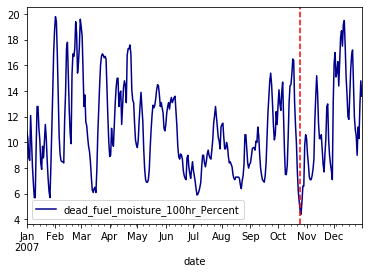

In [109]:
print(overlapFire.perimeter__1)
plt = closeStationDf[mask1].plot(x='date',
                      y='dead_fuel_moisture_100hr_Percent',
                      c='DarkBlue')

plt.axvline(overlapFire.perimeter__1, color="red", linestyle="--")

2006-07-15


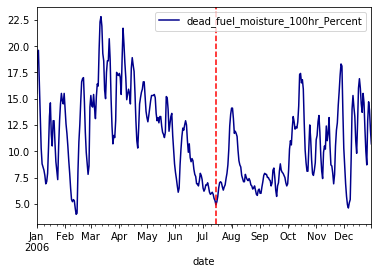

In [110]:
print(overlapFire.perimeter__2)
plt = closeStationDf[mask2].plot(x='date',
                      y='dead_fuel_moisture_100hr_Percent',
                      c='DarkBlue')
plt.axvline(overlapFire.perimeter__2, color="red", linestyle="--")

In [111]:
overlapFire

id_1            view_historical_fires.fid--6c64548_17013a0304a...
year_1                                                       2007
fire_name_1                                                Harris
agency_1                                             State agency
acres_1                                                   65333.8
mapmethod_1                                                  None
inciwebid_1                                                  None
alarm_date_1                                                 None
cont_date_1                                                  None
comments_1                                                   None
complex_na_1                                                 None
perimeter__1                                           2007-10-25
cause_1                                                      None
id_2            view_historical_fires.fid--6c64548_17013a0304a...
year_2                                                       2006
fire_name_